In [1]:
%run utils/image_processing.ipynb

import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
import random

from ipywidgets import FileUpload
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets

import tensorflow as tf
import swifter
from tensorflow import keras
import keras
from tensorflow import feature_column
from tensorflow.keras.models import Sequential
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D

In [2]:
# Location to images and CSV file
DATASET_PATH="datasets/"
DATASET_CSV=DATASET_PATH+"styles.csv"

# Reading Dataset
df_images=pd.read_csv(DATASET_CSV, error_bad_lines=False, warn_bad_lines=False)

# Removing rows containing NULL values
df_images=df_images.dropna().reset_index(drop=True)

# Adding Image_Name for simplification of data
df_images["image_name"]=df_images.apply(lambda row: str(row["id"])+".jpg",axis=1).reset_index(drop=True)

# There are few row ID which does not have corresponding IMAGE 
# in the Image folder. Removing rows that does not have
# corresponding Images
image_files=os.listdir(DATASET_PATH+"images/")
df_images=df_images[df_images["image_name"].isin(image_files)].reset_index(drop=True)

df_images.head(5)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_name
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


In [3]:
# Transfer Learning
# ResNet50 is used to capture the PATTERNS from the images. 
# Using Pre-Trained model, we do not need to retrain from scratch.
# Removed top layer from the neural network as last layer is used for classification.
# Interested only in the second last layer.
# Created a new model with keeping resnet50 as the base model and adding Global Average Pooling layer

img_width, img_height, channels = load_image(DATASET_PATH,df_images.iloc[0].image_name).shape
base_model = ResNet50(weights='imagenet', include_top=False, input_shape = (img_width, img_height, channels))
base_model.trainable = False

model = keras.Sequential([
                    base_model,
                    GlobalMaxPooling2D()
                    ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 3, 2, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


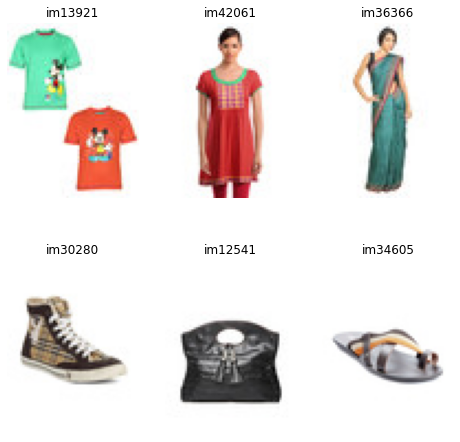

In [4]:
# Displaying Images from the dataset

figures = {'im'+str(i): load_image(DATASET_PATH,row.image_name) for i, row in df_images.sample(6).iterrows()}
plot_images(figures, 2, 3)

In [5]:
# Output from Neural Network is a vector (2048 nodes output embeded into 1 vector). 
# We can use this vector to find distance using cosine or jaccard formula for similarity
# We pass the model and img_name


# Get embeding (vectors) for the entire dataset
def generate_embedings_entire_dataset(model, df_images):
    map_embedings = df_images['image_name'].swifter.apply(lambda img: get_embeding(model, img))
    df_embd = map_embedings.apply(pd.Series)
    df_embd.to_csv("Images_Embeddings.csv")

    #Combining with the dataset to save it and regain easily
    df_embd_with_data=df_images.join(df_embd)
    df_embd_with_data.to_csv("Images_Embeddings_With_Dataset.csv")
    
    return df_embd, df_embd_with_data



# This function is for file/image that will be uploaded
def get_embeding_uploaded(model, img):
    try:
        plt.imshow(img)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return model.predict(x).reshape(-1)
    except:
        print("Error in Image File: ", img_name)
        return [0]*2048

# This function is for the file/image from the dataset
def get_embeding(model, img_name):
    try:
        img = image.load_img(img_path(DATASET_PATH,img_name), target_size=(img_width, img_height))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return model.predict(x).reshape(-1)
    except:
        print("Error in Image File: ", img_name)
        return [0]*2048
    
    
# Find the TOP N images that match to the current image using cosine distance matrix
def similarity_dataset(cosine_matrix, indices,idx, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_matrix[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    return indices.iloc[idx_rec].index, idx_sim


# Uploading image for new recommendation (OUT OF DATASET)
def get_uploaded_image(upload):
    if(len(upload.data)==1):
        nparr = np.frombuffer(upload.data[-1], np.uint8)
        img_np = cv2.imdecode(nparr, flags=1)
        img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
        img_np2=cv2.resize(img_np,(img_height, img_width))
    else:
        print("Image NOT UPLOADED! USING DEFAULT IMAGE")
        img_np=cv2.cvtColor(cv2.imread("./test/img1.jpg"), cv2.COLOR_BGR2RGB)
        img_np2=cv2.resize(img_np,(img_height, img_width))
        
    return img_np2

def calculate_cosine_distances(df_ref, metric="cosine"):
    cosine_distance = 1-pairwise_distances(df_ref, metric=metric)
    indices = pd.Series(range(len(df_ref)), index=df_ref.index)
    
    return cosine_distance, indices


# Run this for Recommendation for UPLOADED_IMAGE
def get_recommendation_from_uploaded_image(upload, df_embeded):
    uploaded_image_temp=get_uploaded_image(upload)
    plt.imshow(uploaded_image_temp)
    plt.title("Actual Image")
    
    test_emd=get_embeding_uploaded(model, uploaded_image_temp)
    test_emd_series=pd.Series(test_emd)

    df_embd_temp=df_embeded.copy()
    df_embd_temp=df_embd_temp.append(test_emd_series, ignore_index=True)
    
    # Calculate the cosine/jaccard distances
    cosine_distance_upload, indices_upload = calculate_cosine_distances(df_embd_temp)
    
    idx_ref = len(df_embd_temp)-1
    idx_rec, idx_sim = similarity_dataset(cosine_distance_upload , indices_upload , idx_ref)

    plt.imshow(uploaded_image_temp)
    figures = {'im'+str(i): load_image(DATASET_PATH,row.image_name) for i, row in df_images.loc[idx_rec].iterrows()}
    plot_images(figures, 2,2 )
    

# Run this for Recommendation from DATASET
def get_recommendation_from_dataset_image(idx, df_embeded, df_images):
    # Calculate the cosine/jaccard distances
    cosine_distance, indices = calculate_cosine_distances(df_embeded)
    
    plt.imshow(cv2.cvtColor(load_image(DATASET_PATH, df_images["image_name"].iloc[idx]), cv2.COLOR_BGR2RGB))
    plt.title("Actual Image")
    idx_rec, idx_sim = similarity_dataset(cosine_distance, indices, idx)

    figures = {'im'+str(i): load_image(DATASET_PATH,row.image_name) for i, row in df_images.loc[idx_rec].iterrows()}
    plot_images(figures, 2,2 )

    

In [6]:
if(os.path.isfile("Images_Embeddings.csv")):
    print("FILE EXISTS!")
    df_embeded= pd.read_csv("Images_Embeddings.csv", index_col=0, nrows=10000)
    df_embeded.columns=df_embeded.columns.map(int)
else:
    df_embeded, _ = generate_embedings_entire_dataset(model, df_images)

FILE EXISTS!


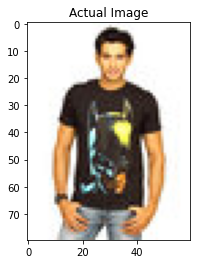

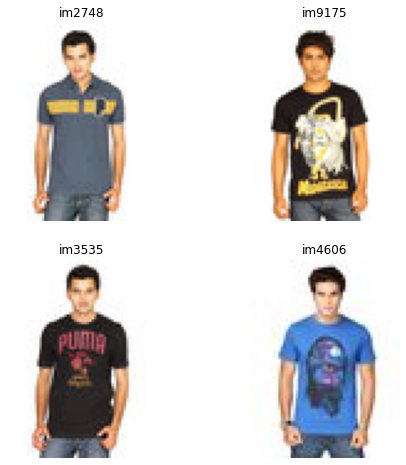

In [7]:
idx = random.randint(0,len(df_embeded))
get_recommendation_from_dataset_image(idx, df_embeded, df_images)

In [8]:
recommend_button = widgets.Button(description='Get Similar Images to Uploaded')
upload = FileUpload(description= " Upload Image for Recommendation")
upload

FileUpload(value={}, description=' Upload Image for Recommendation')

Image NOT UPLOADED! USING DEFAULT IMAGE


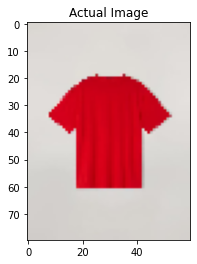

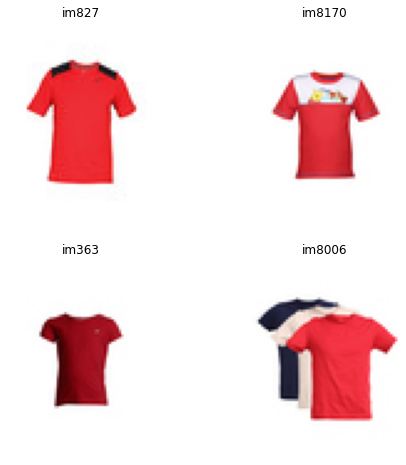

In [9]:
get_recommendation_from_uploaded_image(upload, df_embeded)


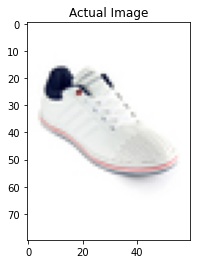

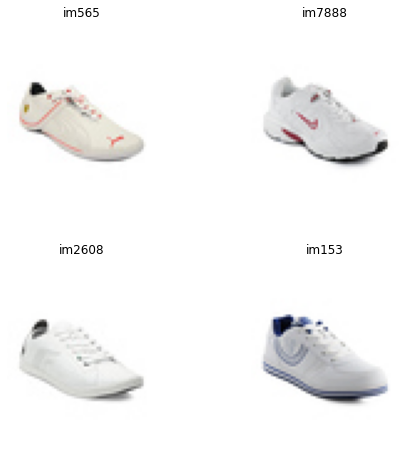

In [10]:
idx = random.randint(0,len(df_embeded))
get_recommendation_from_dataset_image(idx, df_embeded, df_images)